In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pydaptivefiltering as pdf

In [2]:
# --- 1. CONFIGURAÇÃO DO CENÁRIO ---
np.random.seed(10)
n_samples = 2000
filter_order = 7  # 8 taps

# Entrada: Ruído branco complexo
x = (np.random.randn(n_samples) + 1j*np.random.randn(n_samples)) / np.sqrt(2)

# Planta Desconhecida (Sinal Complexo)
w_true = np.array([0.3 + 0.4j, -0.2, 0.5j, 0.1 - 0.1j, -0.3, 0.2j, 0.05, -0.05j])

# Sinal desejado com ruído aditivo
noise_std = 0.05
noise = (noise_std / np.sqrt(2)) * (np.random.randn(n_samples) + 1j*np.random.randn(n_samples))
d = np.zeros(n_samples, dtype=complex)
for k in range(len(w_true), n_samples):
    reg = x[k : k - len(w_true) : -1]
    d[k] = np.vdot(w_true, reg) + noise[k]

# --- 2. EXECUÇÃO DO FILTRO SM-NLMS ---
# gamma_bar: O "pulo do gato". Deve ser ligeiramente maior que o ruído esperado.
# gamma: Regularização para evitar divisão por zero se a energia do regressor for nula.
filt_smnlms = pdf.SMNLMS(
    filter_order=filter_order,
    gamma_bar=0.1,  # Aproximadamente 2x o ruído std
    gamma=1e-4
)

result = filt_smnlms.optimize(x, d, verbose=True, return_internal_states=True)

[SM-NLMS] Updates: 119/2000 (6.0%) | Runtime: 12.504 ms


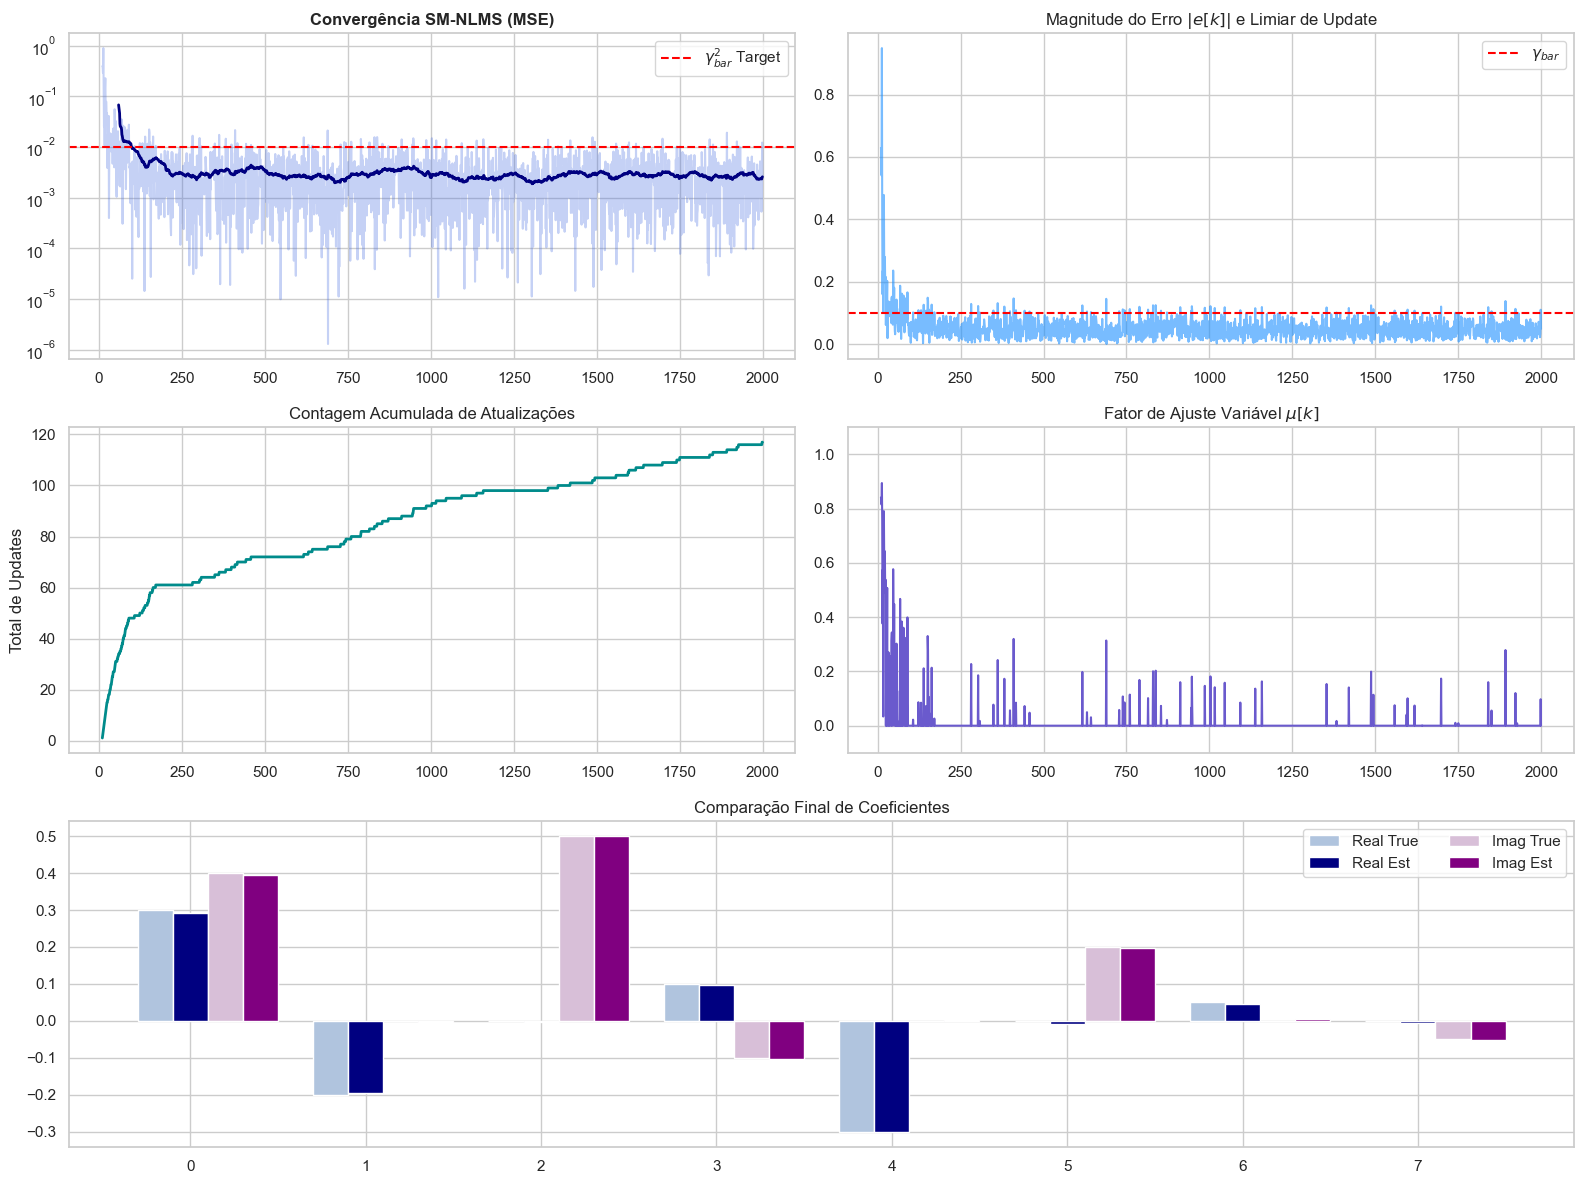

In [3]:
# --- 3. DASHBOARD DE DIAGNÓSTICO ---
def plot_sm_nlms_dashboard(result, w_true, gamma_bar, offset=10):
    sns.set_theme(style="whitegrid")
    
    mse = result.mse()[offset:]
    err_mag = np.abs(result.errors)[offset:]
    t = np.arange(len(result.mse()))[offset:]
    
    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(3, 2)

    # A. Curva de Aprendizado (MSE)
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.semilogy(t, mse, color='royalblue', alpha=0.3)
    ax1.semilogy(t, pd.Series(mse).rolling(50).mean(), color='navy', lw=2)
    ax1.axhline(y=gamma_bar**2, color='red', ls='--', label=r'$\gamma_{bar}^2$ Target')
    ax1.set_title("Convergência SM-NLMS (MSE)", fontweight='bold')
    ax1.legend()

    # B. Magnitude do Erro vs Limiar (Onde a mágica acontece)
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(t, err_mag, color='dodgerblue', alpha=0.6)
    ax2.axhline(y=gamma_bar, color='red', ls='--', label=r'$\gamma_{bar}$')
    ax2.set_title("Magnitude do Erro $|e[k]|$ e Limiar de Update")
    ax2.legend()

    # C. Máscara de Atualização (Atividade do Processador)
    ax3 = fig.add_subplot(gs[1, 0])
    updates = result.extra['update_mask'][offset:]
    ax3.plot(t, np.cumsum(updates), color='darkcyan', lw=2)
    ax3.set_title("Contagem Acumulada de Atualizações")
    ax3.set_ylabel("Total de Updates")

    # D. Trajetória do Step-Size (mu[k])
    ax4 = fig.add_subplot(gs[1, 1])
    mu = result.extra['mu'][offset:]
    ax4.plot(t, mu, color='slateblue')
    ax4.set_title(r"Fator de Ajuste Variável $\mu[k]$")
    ax4.set_ylim(-0.1, 1.1)

    # E. Comparação de Taps Reais e Imaginários
    ax5 = fig.add_subplot(gs[2, :])
    w_final = result.coefficients[-1]
    x_ax = np.arange(len(w_true))
    
    ax5.bar(x_ax - 0.2, w_true.real, 0.2, label='Real True', color='lightsteelblue')
    ax5.bar(x_ax, w_final.real, 0.2, label='Real Est', color='navy')
    ax5.bar(x_ax + 0.2, w_true.imag, 0.2, label='Imag True', color='thistle')
    ax5.bar(x_ax + 0.4, w_final.imag, 0.2, label='Imag Est', color='purple')
    ax5.set_title("Comparação Final de Coeficientes")
    ax5.legend(ncol=2)

    plt.tight_layout()
    plt.show()

plot_sm_nlms_dashboard(result, w_true, filt_smnlms.gamma_bar)